In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Data Cleaning

In [ ]:
df = pd.read_csv("Bank_Loan_Granting.csv")
df.head()

ID  Age  Experience  Income  ZIP Code  Family CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4  1/60          1         0   
1   2   45          19      34     90089       3  1/50          1         0   
2   3   39          15      11     94720       1  1/00          1         0   
3   4   35           9     100     94112       1  2/70          2         0   
4   5   35           8      45     91330       4  1/00          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

### checking null values

In [ ]:
df.info()
#no null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  5000 non-null   int64 
 1   Age                 5000 non-null   int64 
 2   Experience          5000 non-null   int64 
 3   Income              5000 non-null   int64 
 4   ZIP Code            5000 non-null   int64 
 5   Family              5000 non-null   int64 
 6   CCAvg               5000 non-null   object
 7   Education           5000 non-null   int64 
 8   Mortgage            5000 non-null   int64 
 9   Personal Loan       5000 non-null   int64 
 10  Securities Account  5000 non-null   int64 
 11  CD Account          5000 non-null   int64 
 12  Online              5000 non-null   int64 
 13  CreditCard          5000 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 547.0+ KB


im not gonna remove "ID" column because i think it'll come in handy. Based on my analysis experiences, "ID" column may always increase the accuracy rate than being removed

### checking duplicated values

In [ ]:
df.duplicated().sum()

0

### correcting values to appropriate format

Notice there's an object type variable. Since the variable 'CCAvg' represents the average monthly credit card spending, it seems like a typo. It should be '.' instead of '/', indicating decimal numbers with data type float

In [ ]:
df["CCAvg"] = df["CCAvg"].str.replace('/',".").astype(float)
df.head()

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


The variable 'CCAvg' has been successfully converted to a float data type

### checking dirty values by its length

In [ ]:
discrete_col = ["Family","Education","Personal Loan","Securities Account","CD Account","Online","CreditCard"]
numeric_col = [col for col in df.columns if col not in discrete_col]

In [ ]:
for col in df.columns:
    print(f"the range of col-{col} uis between {df[col].min()} to {df[col].max()}")

the range of col-ID uis between 1 to 5000
the range of col-Age uis between 23 to 67
the range of col-Experience uis between -3 to 43
the range of col-Income uis between 8 to 224
the range of col-ZIP Code uis between 9307 to 96651
the range of col-Family uis between 1 to 4
the range of col-CCAvg uis between 0.0 to 10.0
the range of col-Education uis between 1 to 3
the range of col-Mortgage uis between 0 to 635
the range of col-Personal Loan uis between 0 to 1
the range of col-Securities Account uis between 0 to 1
the range of col-CD Account uis between 0 to 1
the range of col-Online uis between 0 to 1
the range of col-CreditCard uis between 0 to 1


Notice that the 'Experience' variable has negative values. In the context of experience, there should never be negative data. I assume that these negative values are just typos. Therefore, I will change all negative values in the 'Experience' variable to their absolute values.

In [ ]:
df["Experience"] = df["Experience"].abs()
(df["Experience"] < 0).sum()

0

all negative values are already changed to its positive

### cardinality checking for categorical or discrete values

In [ ]:
unique = [df[col].value_counts() for col in discrete_col]
unique

[Family
 1    1472
 2    1296
 4    1222
 3    1010
 Name: count, dtype: int64,
 Education
 1    2096
 3    1501
 2    1403
 Name: count, dtype: int64,
 Personal Loan
 0    4520
 1     480
 Name: count, dtype: int64,
 Securities Account
 0    4478
 1     522
 Name: count, dtype: int64,
 CD Account
 0    4698
 1     302
 Name: count, dtype: int64,
 Online
 1    2984
 0    2016
 Name: count, dtype: int64,
 CreditCard
 0    3530
 1    1470
 Name: count, dtype: int64]

Based on the unique results for categorical and discrete variables, it's found that there are 3 variables considered as imbalanced which are "Personal Loan", "Securities Account", and "CD Account."

### checking outliers

In [ ]:
total = 0
checking_col = [col for col in df.columns if col not in ["Personal Loan", "Securities Account", "CD Account."]
]

for col in checking_col:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    outliers = df[(df[col] < (q1 - 1.5*iqr)) | (df[col] > (q3 + 1.5*iqr))]

    length = len(outliers)
    total = total+length
    print(f"column {col} has {length} outliers")

print("\ntotal outliers is", total,"out of", len(df))

column ID has 0 outliers
column Age has 0 outliers
column Experience has 0 outliers
column Income has 96 outliers
column ZIP Code has 1 outliers
column Family has 0 outliers
column CCAvg has 324 outliers
column Education has 0 outliers
column Mortgage has 291 outliers
column CD Account has 302 outliers
column Online has 0 outliers
column CreditCard has 0 outliers

total outliers is 1014 out of 5000


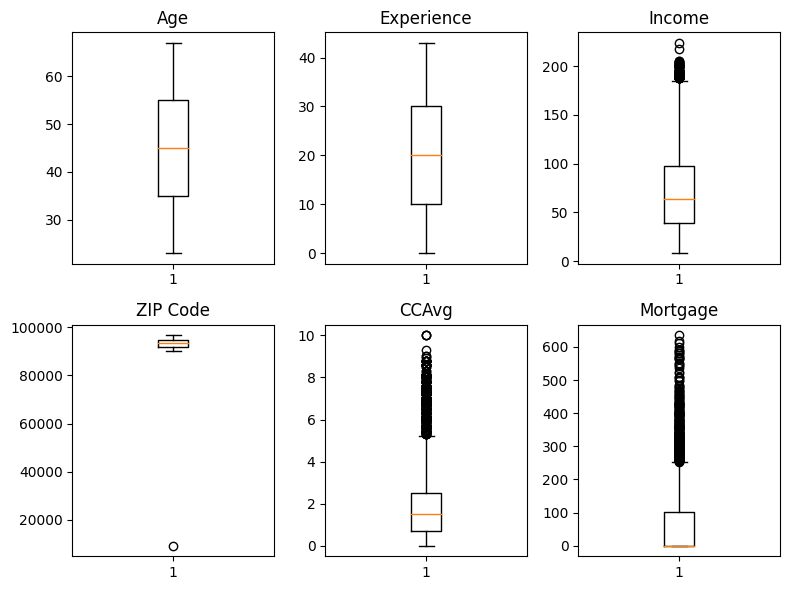

In [ ]:
# for numeric columns only
fig,axes = plt.subplots(2,3, figsize=(8,6))
axes = axes.flatten()

numeric = [col for col in numeric_col if col!="ID"]

for i, name in enumerate(numeric):
    ax = axes[i]
    ax.boxplot(df[name])
    ax.set_title(name)

plt.tight_layout()

- Because there are too many outliers, I will not remove outlier data. Instead, I will use robust scaling to anticipate them
- As there is only 1 empty value in the ZIP Code, I will remove outlier data only in this part, so as not to affect other data

In [ ]:
q1 = df["ZIP Code"].quantile(0.25)
q3 = df["ZIP Code"].quantile(0.75)
iqr = q3-q1
outliers = df[(df["ZIP Code"] < (q1 - 1.5*iqr)) | (df["ZIP Code"] > (q3 + 1.5*iqr))]
outliers

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  \
384  385   51          25      21      9307       4    0.6          3   

     Mortgage  Personal Loan  Securities Account  CD Account  Online  \
384         0              0                   0           0       1   

     CreditCard  
384           1

In [ ]:
df.drop(index=384, inplace=True)
len(df)

4999

outliers pada variable "ZIP Code" berhasil diremove, dan total baris/data berkurang 1

In [ ]:
df[numeric_col].describe()

ID          Age   Experience       Income      ZIP Code  \
count  4999.000000  4999.000000  4999.000000  4999.000000   4999.000000   
mean   2500.923185    45.337267    20.133627    73.784757  93169.275455   
std    1443.354188    11.464033    11.416124    46.032281   1759.630610   
min       1.000000    23.000000     0.000000     8.000000  90005.000000   
25%    1251.500000    35.000000    10.000000    39.000000  91911.000000   
50%    2501.000000    45.000000    20.000000    64.000000  93437.000000   
75%    3750.500000    55.000000    30.000000    98.000000  94608.000000   
max    5000.000000    67.000000    43.000000   224.000000  96651.000000   

             CCAvg     Mortgage  
count  4999.000000  4999.000000  
mean      1.938206    56.510102  
std       1.747731   101.720837  
min       0.000000     0.000000  
25%       0.700000     0.000000  
50%       1.500000     0.000000  
75%       2.500000   101.000000  
max      10.000000   635.000000

# Data Visualization

In [ ]:
df2 = df.copy()
df2 .drop(columns="ID",inplace=True)

In [ ]:
df2.head()

Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   45          19      34     90089       3    1.5          1         0   
2   39          15      11     94720       1    1.0          1         0   
3   35           9     100     94112       1    2.7          2         0   
4   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

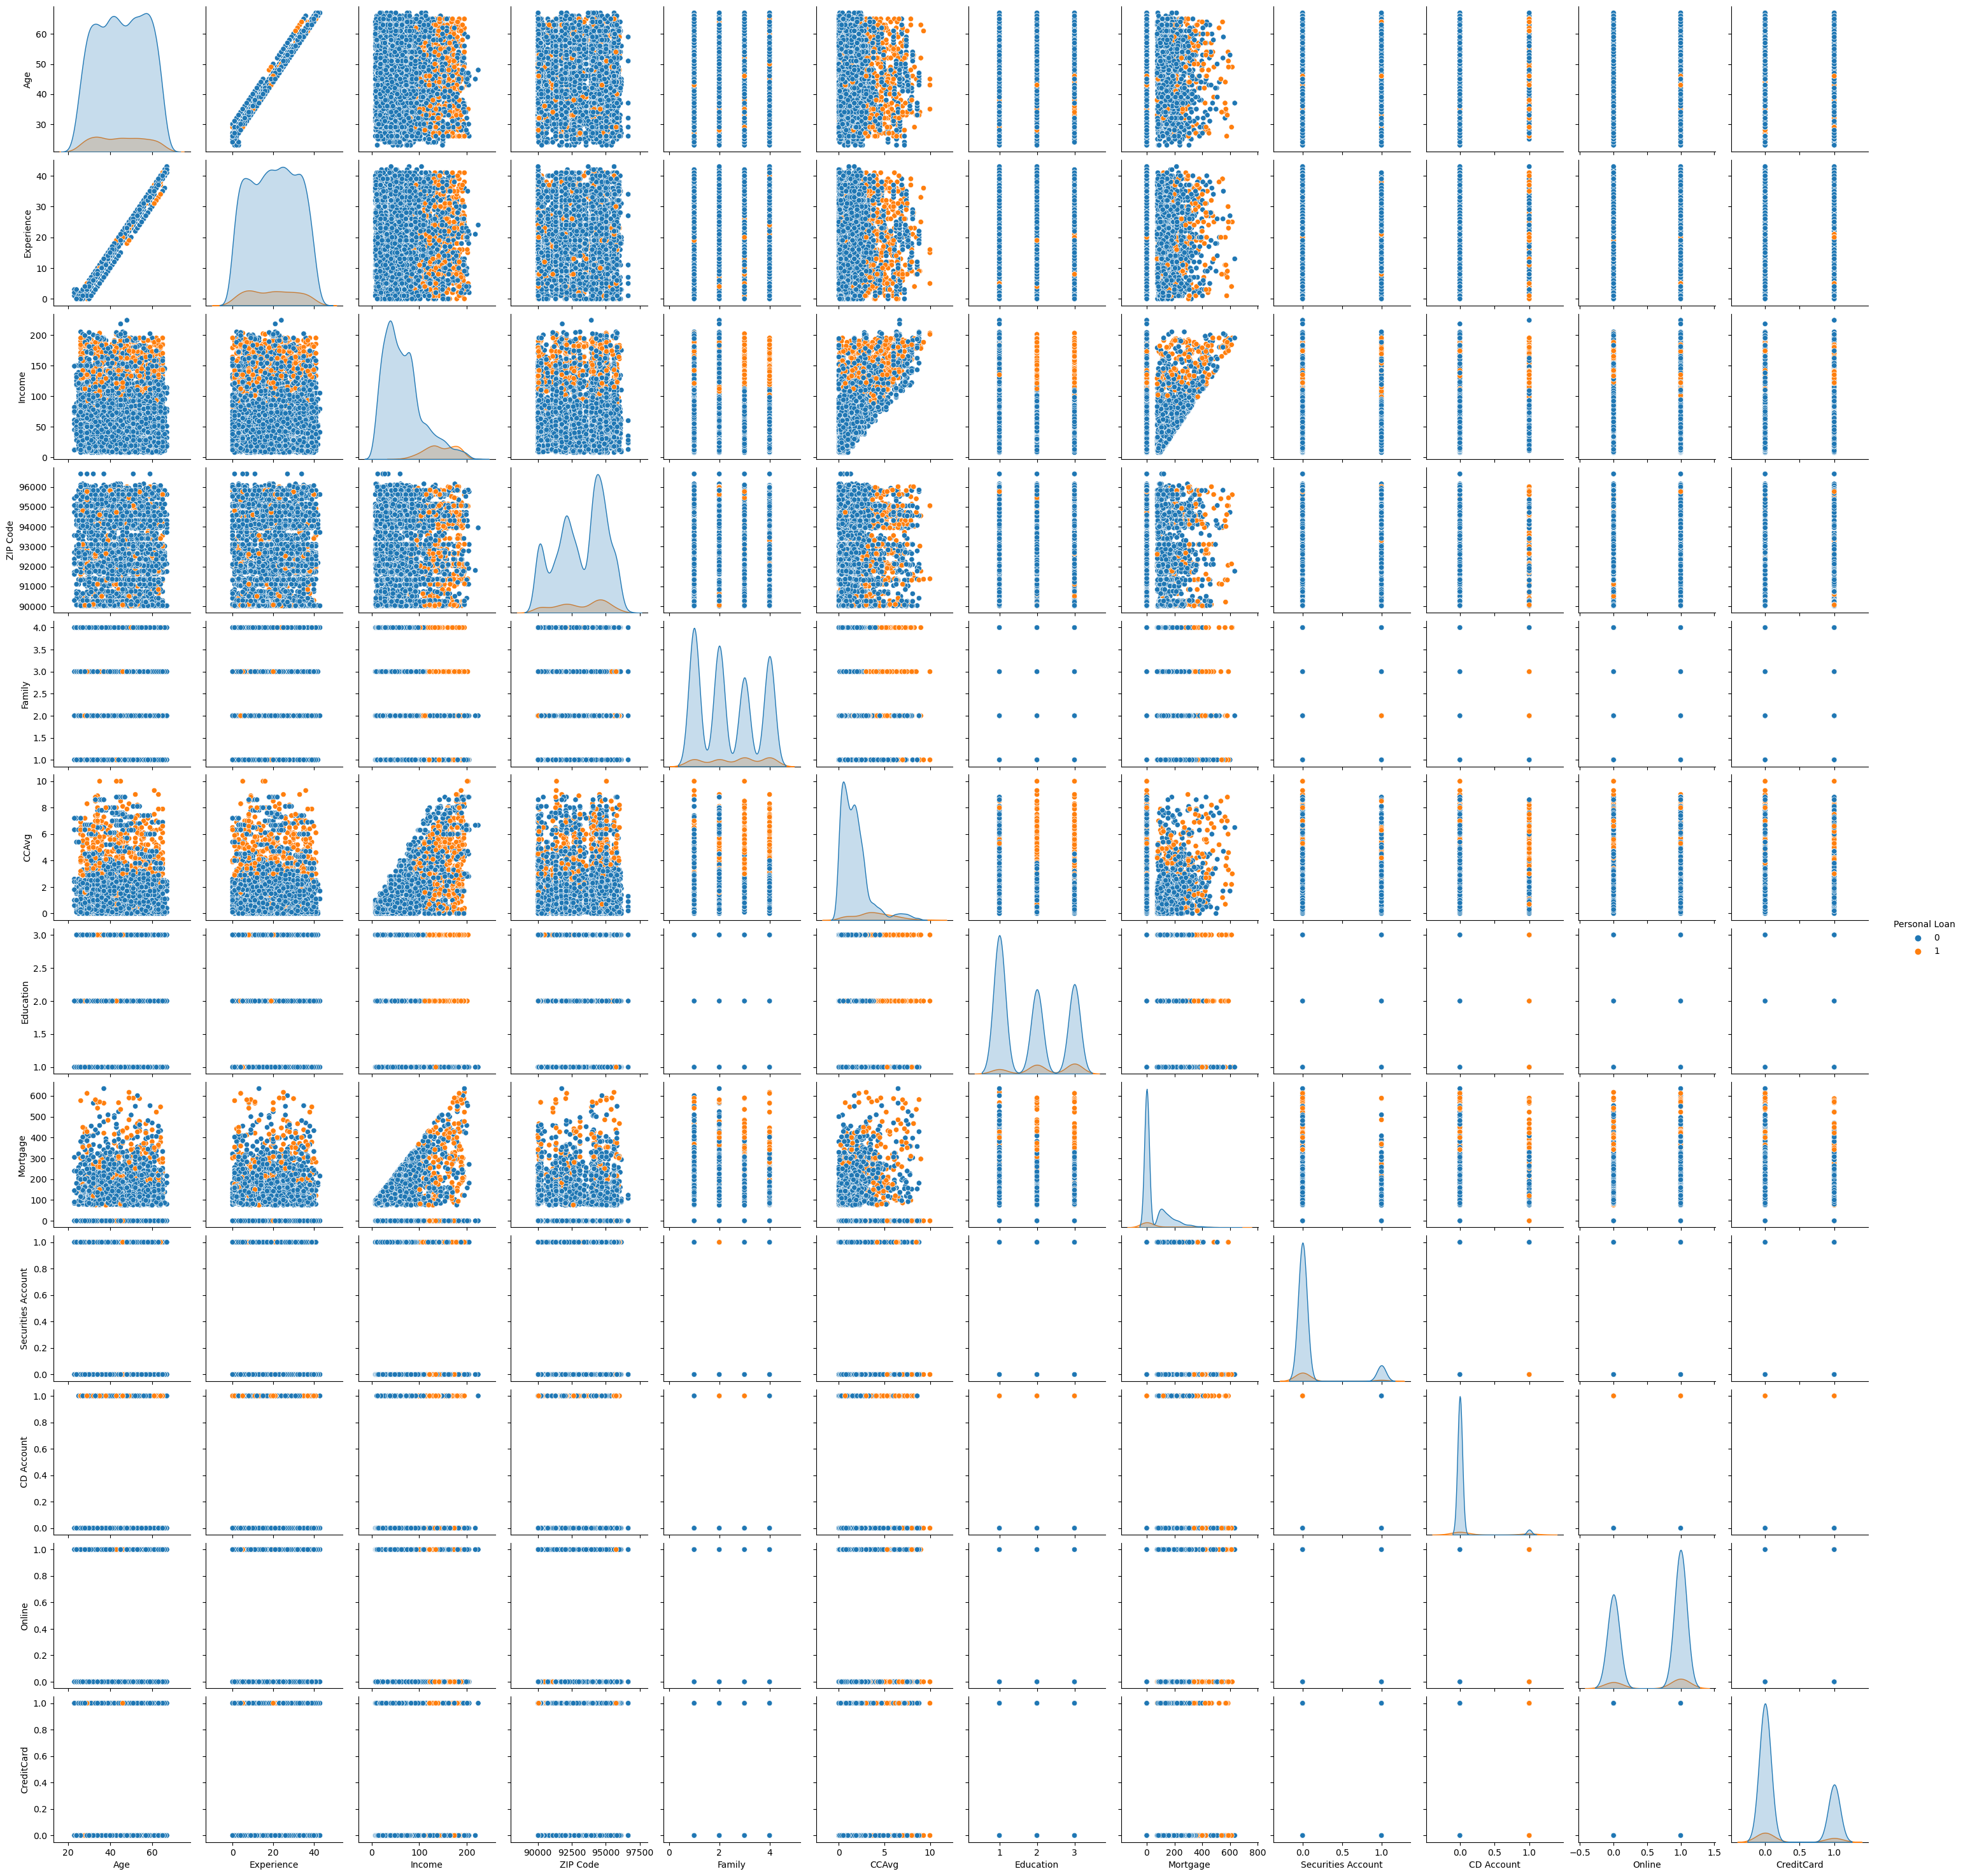

In [ ]:
sns.pairplot(df2, hue='Personal Loan')
plt.show()

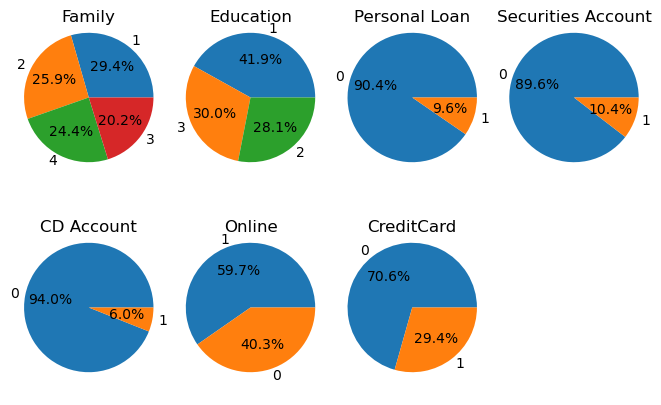

In [ ]:
fig,axes = plt.subplots(2,4, figsize=(8,5))
axes = axes.flatten()

for i, name in enumerate(discrete_col):
    ax = axes[i]
    counts = df2[name].value_counts()
    ax.pie(counts, labels = counts.index, autopct="%1.1f%%",radius=1.2)
    ax.set_title(name)

for ax in axes:
    ax.axis('off')

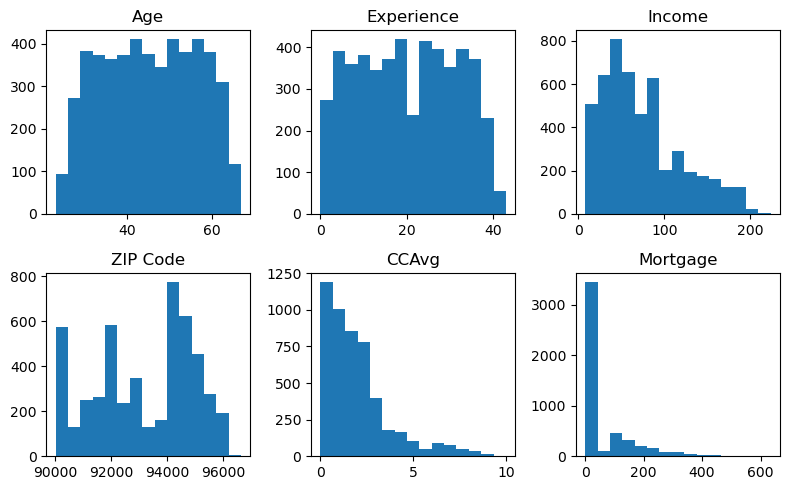

In [ ]:
fig,axes = plt.subplots(2,3, figsize=(8,5))
axes = axes.flatten()

for i, name in enumerate(numeric):
    ax = axes[i]
    ax.hist(df2[name], label=name,bins=15)
    ax.set_title(name)

plt.tight_layout()

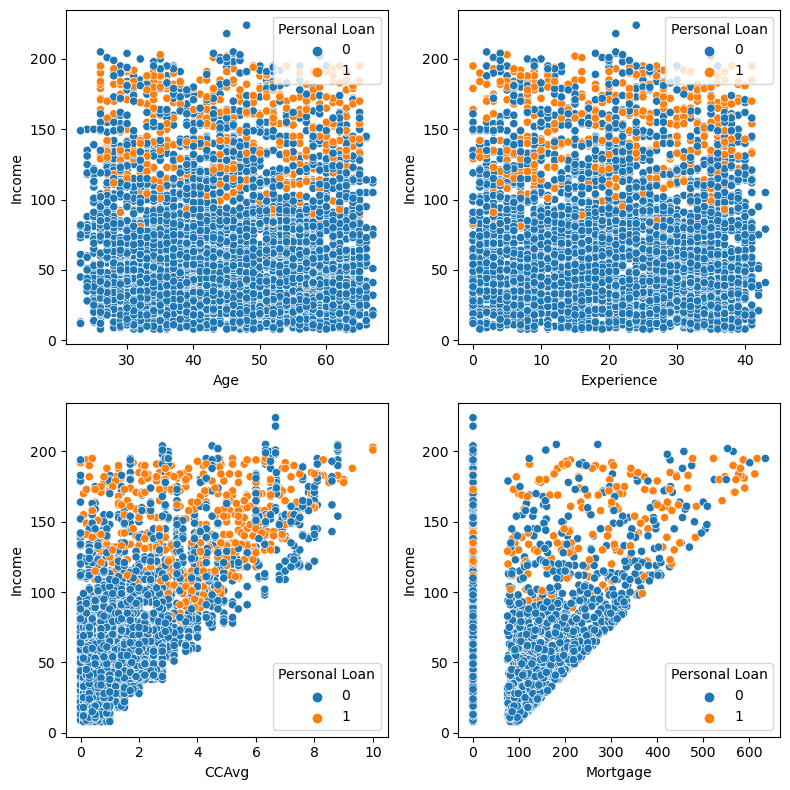

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.flatten()

numeric = [col for col in numeric_col if col not in ["ID", "Income", "ZIP Code"]]

for i, name in enumerate(numeric):
    ax = axes[i]
    sns.scatterplot(data=df2, x=name, y="Income", hue="Personal Loan", ci=None, ax=ax)

plt.tight_layout()

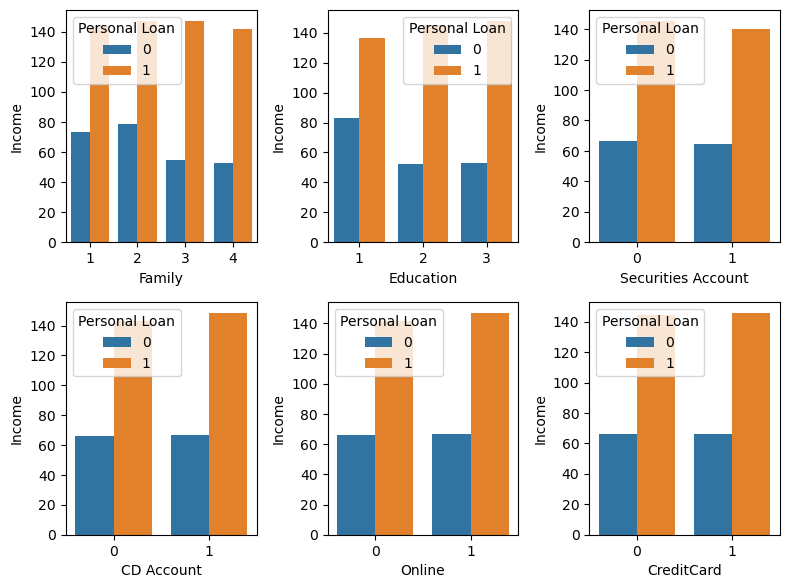

In [ ]:
fig,axes = plt.subplots(2,3, figsize=(8,6))
axes = axes.flatten()

discrete = [col for col in discrete_col if col != "Personal Loan"]

for i, name in enumerate(discrete):
    ax = axes[i]
    sns.barplot(data=df2, x=name, y="Income", hue="Personal Loan", ci=None, ax=ax)

plt.tight_layout()

# Data Preparation

### encoding for categorical or discrete values

I will only create dummies for discrete variables family and education that have multiple labels

In [ ]:
df_encode=pd.get_dummies(df,columns=["Family","Education"])
df_encode

ID  Age  Experience  Income  ZIP Code  CCAvg  Mortgage  Personal Loan  \
0        1   25           1      49     91107    1.6         0              0   
1        2   45          19      34     90089    1.5         0              0   
2        3   39          15      11     94720    1.0         0              0   
3        4   35           9     100     94112    2.7         0              0   
4        5   35           8      45     91330    1.0         0              0   
...    ...  ...         ...     ...       ...    ...       ...            ...   
4995  4996   29           3      40     92697    1.9         0              0   
4996  4997   30           4      15     92037    0.4        85              0   
4997  4998   63          39      24     93023    0.3         0              0   
4998  4999   65          40      49     90034    0.5         0              0   
4999  5000   28           4      83     92612    0.8         0              0   

      Securities Account  CD Account  Online  CreditCard  Family_1  Family_2  \
0                      1           0       0           0     False     False   
1                      1           0       0           0     False     False   
2                      0           0       0           0      True     False   
3                      0           0       0           0      True     False   
4                      0           0       0           1     False     False   
...                  ...         ...     ...         ...       ...       ...   
4995                   0           0       1           0      True     False   
4996                   0           0       1           0     False     False   
4997                   0           0       0           0     False      True   
4998                   0           0       1           0     False     False   
4999                   0           0       1           1     False     False   

      Family_3  Family_4  Education_1  Education_2  Education_3  
0        False      True         True        False        False  
1         True     False         True        False        False  
2        False     False         True        False        False  
3        False     False        False         True        False  
4        False      True        False         True        False  
...        ...       ...          ...          ...          ...  
4995     False     False        False        False         True  
4996     False      True         True        False        False  
4997     False     False        False        False         True  
4998      True     False        False         True        False  
4999      True     False         True        False        False  

[4999 rows x 19 columns]

### Splitting

In [ ]:
input_df = df_encode.drop(columns="Personal Loan")
output_df = df_encode["Personal Loan"]

x_train, x_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.2, random_state=0)
x_test,x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5,random_state=0 )

In [ ]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(3999, 18) (3999,)
(500, 18) (500,)
(500, 18) (500,)


### Scalling

In [ ]:
scaler = RobustScaler()
x_train[numeric_col] = scaler.fit_transform(x_train[numeric_col])
x_val[numeric_col] = scaler.transform(x_val[numeric_col])
x_test[numeric_col] = scaler.transform(x_test[numeric_col])

In [ ]:
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [ ]:
x_train

ID   Age  Experience    Income  ZIP Code  CCAvg  Mortgage  \
2616  0.044409  0.55        0.55 -0.233333 -0.500373    1.6      1.03   
1117 -0.555311 -0.15       -0.10  1.366667  0.441834    1.7      1.32   
4520  0.806161 -0.65       -0.65 -0.366667  0.440716    2.0      0.00   
1479 -0.410482 -0.85       -0.80 -0.333333 -0.827740    1.0      1.02   
156  -0.939788 -0.95       -1.00 -0.800000 -0.519389    0.4      0.00   
...        ...   ...         ...       ...       ...    ...       ...   
4932  0.970994  0.70        0.75  0.800000 -0.901193    4.3      0.00   
3265  0.304061 -0.25       -0.30 -0.033333  0.405667    0.5      0.00   
1654 -0.340468  0.75        0.70  0.650000  0.291201    2.0      0.00   
2608  0.041208  0.80        0.75  0.266667  0.186428    2.0      1.94   
2733  0.091218  0.50        0.45  0.150000 -0.155481    0.3      1.47   

      Securities Account  CD Account  Online  CreditCard  Family_1  Family_2  \
2616                 0.0         0.0     0.0         0.0       0.0       1.0   
1117                 0.0         0.0     0.0         1.0       1.0       0.0   
4520                 0.0         0.0    -1.0         0.0       0.0       0.0   
1479                 0.0         0.0    -1.0         0.0       1.0       0.0   
156                  0.0         0.0    -1.0         1.0       0.0       0.0   
...                  ...         ...     ...         ...       ...       ...   
4932                 0.0         0.0     0.0         0.0       1.0       0.0   
3265                 0.0         0.0     0.0         0.0       0.0       0.0   
1654                 0.0         0.0     0.0         1.0       0.0       1.0   
2608                 0.0         0.0     0.0         1.0       0.0       1.0   
2733                 0.0         0.0    -1.0         0.0       0.0       0.0   

      Family_3  Family_4  Education_1  Education_2  Education_3  
2616       0.0       0.0          0.0          0.0          1.0  
1117       0.0       0.0          1.0          0.0          0.0  
4520       0.0       1.0          0.0          1.0          0.0  
1479       0.0       0.0          0.0          0.0          1.0  
156        0.0       1.0          1.0          0.0          0.0  
...        ...       ...          ...          ...          ...  
4932       0.0       0.0          1.0          0.0          0.0  
3265       1.0       0.0          0.0          0.0          1.0  
1654       0.0       0.0          1.0          0.0          0.0  
2608       0.0       0.0          1.0          0.0          0.0  
2733       1.0       0.0          0.0          1.0          0.0  

[3999 rows x 18 columns]

### creating tensor dataset

In [ ]:
train_df = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_df = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(16)
val_df = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(16)

# Creating Model

Because the target variable consists of imbalanced data, therefore the appropriate evaluation metric to use is the 'f1-score'

### creating functions

In [ ]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

In [ ]:
def graph_loss():
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epoch_count = range(1, len(train_loss) + 1)

    plt.plot(epoch_count, train_loss, 'b', label="train_loss")
    plt.plot(epoch_count, val_loss, 'r', label="val_loss")
    plt.title(f"Loss graph of {model_name}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### model1 (sigmoid)

In [ ]:
model1 = Sequential([
    Dense(18, activation="relu", input_shape=(18,)),
    Dense(36, activation="relu"),
    Dense(36, activation="relu"),
    Dense(1, activation="sigmoid")
])
model1.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 18)                342       
                                                                 
 dense_101 (Dense)           (None, 36)                684       
                                                                 
 dense_102 (Dense)           (None, 36)                1332      
                                                                 
 dense_103 (Dense)           (None, 1)                 37        
                                                                 
Total params: 2395 (9.36 KB)
Trainable params: 2395 (9.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model1.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=[f1_score])

early_stopping = EarlyStopping(mode="max", patience=5, restore_best_weights=True)

model_history = model1.fit(train_df, validation_data=val_df, epochs=120,
                              callbacks=[early_stopping])

Epoch 1/120
250/250 [==============================] - 2s 2ms/step - loss: 0.2651 - f1_score: 0.1055 - val_loss: 0.1739 - val_f1_score: 0.3179
Epoch 2/120
250/250 [==============================] - 0s 2ms/step - loss: 0.1111 - f1_score: 0.5464 - val_loss: 0.1050 - val_f1_score: 0.5362
Epoch 3/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0781 - f1_score: 0.6480 - val_loss: 0.0766 - val_f1_score: 0.6799
Epoch 4/120
250/250 [==============================] - 1s 2ms/step - loss: 0.0641 - f1_score: 0.6751 - val_loss: 0.0637 - val_f1_score: 0.7076
Epoch 5/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0572 - f1_score: 0.6862 - val_loss: 0.0574 - val_f1_score: 0.7138
Epoch 6/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0528 - f1_score: 0.6873 - val_loss: 0.0540 - val_f1_score: 0.7451


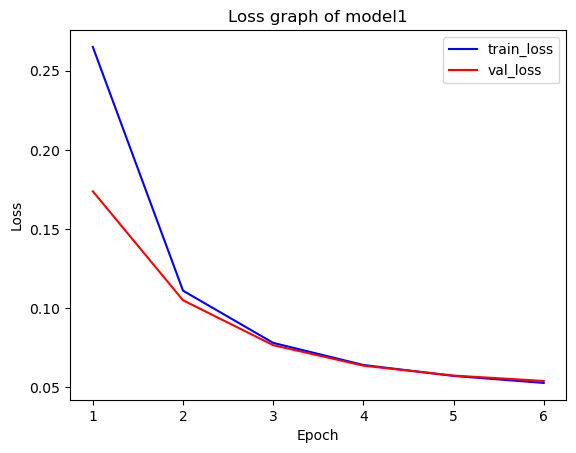

In [ ]:
model_name= "model1"
graph_loss()

In [ ]:
model1.evaluate(test_df)

32/32 [==============================] - 0s 2ms/step - loss: 0.1478 - f1_score: 0.3195


[0.1477811634540558, 0.3194940388202667]

In [ ]:
y_pred1 = model1.predict(x_test)
y_pred1 = np.round(y_pred1)
print("Classification Report: \n", classification_report(y_test, y_pred1))

16/16 [==============================] - 0s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       456
           1       0.94      0.39      0.55        44

    accuracy                           0.94       500
   macro avg       0.94      0.69      0.76       500
weighted avg       0.94      0.94      0.93       500



In [ ]:
y_pred1 = model1.predict(x_test)
y_pred[0]

16/16 [==============================] - 0s 2ms/step


array([0.], dtype=float32)

### model2 (softmax)

In [ ]:
model2 = Sequential([
    Dense(18, activation="relu", input_shape=(18,)),
    Dense(36, activation="relu"),
    Dense(36, activation="relu"),
    Dense(2, activation="softmax")
])
model2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 18)                342       
                                                                 
 dense_105 (Dense)           (None, 36)                684       
                                                                 
 dense_106 (Dense)           (None, 36)                1332      
                                                                 
 dense_107 (Dense)           (None, 2)                 74        
                                                                 
Total params: 2432 (9.50 KB)
Trainable params: 2432 (9.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2.compile(optimizer='Adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[f1_score])

early_stopping = EarlyStopping(mode="max", patience=5, restore_best_weights=True)

model_history = model2.fit(train_df, validation_data=val_df, epochs=120,
                              callbacks=[early_stopping])

Epoch 1/120
250/250 [==============================] - 1s 2ms/step - loss: 0.2255 - f1_score: 0.1648 - val_loss: 0.1594 - val_f1_score: 0.1881
Epoch 2/120
250/250 [==============================] - 0s 2ms/step - loss: 0.1039 - f1_score: 0.1648 - val_loss: 0.0905 - val_f1_score: 0.1881
Epoch 3/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0744 - f1_score: 0.1648 - val_loss: 0.0730 - val_f1_score: 0.1881
Epoch 4/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0612 - f1_score: 0.1648 - val_loss: 0.0645 - val_f1_score: 0.1881
Epoch 5/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0540 - f1_score: 0.1648 - val_loss: 0.0602 - val_f1_score: 0.1881
Epoch 6/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0491 - f1_score: 0.1648 - val_loss: 0.0573 - val_f1_score: 0.1881


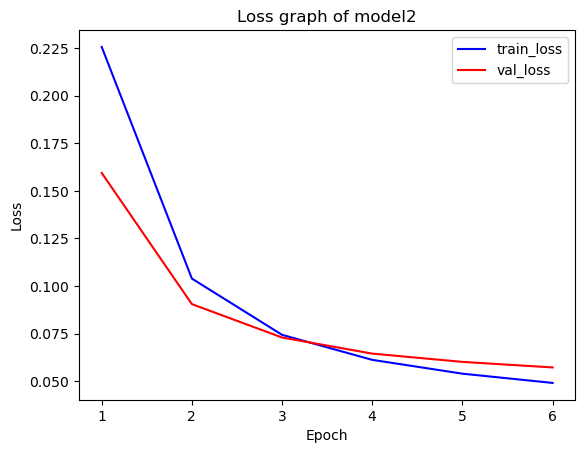

In [ ]:
model_name= "model2"
graph_loss()

In [ ]:
model2.evaluate(test_df)

32/32 [==============================] - 0s 2ms/step - loss: 0.1430 - f1_score: 0.1514


[0.14300255477428436, 0.15135447680950165]

In [ ]:
y_pred2 = model2.predict(x_test)
y_pred2 = np.argmax(y_pred2, axis=1)
print("Classification Report: \n", classification_report(y_test, y_pred2))

16/16 [==============================] - 0s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       456
           1       0.92      0.55      0.69        44

    accuracy                           0.96       500
   macro avg       0.94      0.77      0.83       500
weighted avg       0.95      0.96      0.95       500



In [ ]:
y_pred2 = model2.predict(x_test)
y_pred2[0]

16/16 [==============================] - 0s 2ms/step


array([0.98832625, 0.01167375], dtype=float32)

# 1f. modificated models
## Drop out layers

In [ ]:
model3 = Sequential([
    Dense(18, activation="relu", input_shape=(18,)),
    Dropout(0.2),
    Dense(36, activation="relu"),
    Dropout(0.2),
    Dense(36, activation="relu"),
    Dense(2, activation="softmax")
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 18)                342       
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense_13 (Dense)            (None, 36)                684       
                                                                 
 dropout_1 (Dropout)         (None, 36)                0         
                                                                 
 dense_14 (Dense)            (None, 36)                1332      
                                                                 
 dense_15 (Dense)            (None, 2)                 74        
                                                                 
Total params: 2432 (9.50 KB)
Trainable params: 2432 (9

In [ ]:
model3.compile(optimizer='Adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[f1_score])

early_stopping = EarlyStopping(mode="max", patience=5, restore_best_weights=True)

model_history = model3.fit(train_df, validation_data=val_df, epochs=120,
                              callbacks=[early_stopping])

Epoch 1/120
250/250 [==============================] - 2s 3ms/step - loss: 0.2496 - f1_score: 0.1648 - val_loss: 0.1836 - val_f1_score: 0.1881
Epoch 2/120
250/250 [==============================] - 0s 2ms/step - loss: 0.1517 - f1_score: 0.1648 - val_loss: 0.1464 - val_f1_score: 0.1881
Epoch 3/120
250/250 [==============================] - 1s 2ms/step - loss: 0.1260 - f1_score: 0.1648 - val_loss: 0.1127 - val_f1_score: 0.1881
Epoch 4/120
250/250 [==============================] - 1s 2ms/step - loss: 0.1115 - f1_score: 0.1648 - val_loss: 0.1023 - val_f1_score: 0.1881
Epoch 5/120
250/250 [==============================] - 1s 2ms/step - loss: 0.0972 - f1_score: 0.1648 - val_loss: 0.0891 - val_f1_score: 0.1881
Epoch 6/120
250/250 [==============================] - 1s 2ms/step - loss: 0.0892 - f1_score: 0.1648 - val_loss: 0.0852 - val_f1_score: 0.1881


In [ ]:
model3.evaluate(test_df)

32/32 [==============================] - 0s 2ms/step - loss: 0.1461 - f1_score: 0.1514


[0.1461060494184494, 0.15135447680950165]

In [ ]:
y_pred3 = model3.predict(x_test)
y_pred3 = np.argmax(y_pred3, axis=1)
print("Classification Report: \n", classification_report(y_test, y_pred3))

16/16 [==============================] - 0s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       456
           1       0.96      0.50      0.66        44

    accuracy                           0.95       500
   macro avg       0.96      0.75      0.82       500
weighted avg       0.95      0.95      0.95       500



# SWOT

In [ ]:
df["Personal Loan"].value_counts()

0    4519
1     480
Name: Personal Loan, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

input_df = df_encode.drop(columns=["Personal Loan", "CCAvg"])
output_df = df_encode["Personal Loan"]

smote = SMOTE(sampling_strategy='minority')
input_df_sm, output_df_sm = smote.fit_resample(input_df, output_df)

output_df_sm.value_counts()

0    4519
1    4519
Name: Personal Loan, dtype: int64

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
x_train_sw, x_test_sw, y_train_sw, y_test_sw = train_test_split(input_df_sm, output_df_sm, test_size=0.2, random_state=0)
x_test_sw, x_val_sw, y_test_sw, y_val_sw = train_test_split(x_test_sw, y_test_sw, test_size=0.5,random_state=0 )

In [ ]:
numeric_col = x_train_sw.columns

scaler = RobustScaler()
x_train_sw[numeric_col] = scaler.fit_transform(x_train_sw[numeric_col])
x_val_sw[numeric_col] = scaler.transform(x_val_sw[numeric_col])
x_test_sw[numeric_col] = scaler.transform(x_test_sw[numeric_col])

In [ ]:
train_df_sw = tf.data.Dataset.from_tensor_slices((x_train_sw, y_train_sw)).batch(16)
test_df_sw = tf.data.Dataset.from_tensor_slices((x_val_sw, y_test_sw)).batch(16)
val_df_sw = tf.data.Dataset.from_tensor_slices((x_test_sw, y_val_sw)).batch(16)

In [ ]:
model4 = Sequential([
    Dense(18, activation="relu", input_shape=(17,)),
    Dense(36, activation="relu"),
    Dense(36, activation="relu"),
    Dense(2, activation="softmax")
])
model4.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 18)                324       
                                                                 
 dense_80 (Dense)            (None, 36)                684       
                                                                 
 dense_81 (Dense)            (None, 36)                1332      
                                                                 
 dense_82 (Dense)            (None, 2)                 74        
                                                                 
Total params: 2414 (9.43 KB)
Trainable params: 2414 (9.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model4.compile(optimizer='Adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[f1_score])

early_stopping = EarlyStopping(mode="max", patience=5, restore_best_weights=True)

model_history = model4.fit(train_df_sw, validation_data=val_df_sw, epochs=120,
                              callbacks=[early_stopping])

Epoch 1/120
452/452 [==============================] - 3s 2ms/step - loss: 0.2423 - f1_score: 0.6588 - val_loss: 0.7367 - val_f1_score: 0.1285
Epoch 2/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0795 - f1_score: 0.6588 - val_loss: 0.8747 - val_f1_score: 0.1285
Epoch 3/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0562 - f1_score: 0.6588 - val_loss: 0.9969 - val_f1_score: 0.1285
Epoch 4/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0461 - f1_score: 0.6588 - val_loss: 1.0493 - val_f1_score: 0.1285
Epoch 5/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0405 - f1_score: 0.6588 - val_loss: 1.0710 - val_f1_score: 0.1285
Epoch 6/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0369 - f1_score: 0.6588 - val_loss: 1.1351 - val_f1_score: 0.1285
Epoch 7/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0346 - f1_score: 0.6588 - val_loss: 1.1639 - val_f1_score: 0.1285

Epoch 58/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0050 - f1_score: 0.6588 - val_loss: 4.1741 - val_f1_score: 0.1285
Epoch 59/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0078 - f1_score: 0.6588 - val_loss: 4.3805 - val_f1_score: 0.1285
Epoch 60/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0072 - f1_score: 0.6588 - val_loss: 4.4503 - val_f1_score: 0.1285
Epoch 61/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0098 - f1_score: 0.6588 - val_loss: 3.7399 - val_f1_score: 0.1285
Epoch 62/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0064 - f1_score: 0.6588 - val_loss: 3.8494 - val_f1_score: 0.1285
Epoch 63/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0042 - f1_score: 0.6588 - val_loss: 3.8699 - val_f1_score: 0.1285
Epoch 64/120
452/452 [==============================] - 1s 2ms/step - loss: 0.0043 - f1_score: 0.6588 - val_loss: 4.0442 - val_f1_score:

In [ ]:
model4.evaluate(test_df_sw)

16/16 [==============================] - 0s 2ms/step - loss: 2.2676 - f1_score: 0.1886


[2.2675538063049316, 0.1885823756456375]

In [ ]:
y_pred4 = model4.predict(x_test_sw)
y_pred4 = np.argmax(y_pred4, axis=1)
print("Classification Report: \n", classification_report(y_test_sw, y_pred4))

29/29 [==============================] - 0s 1ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       447
           1       0.98      0.99      0.98       457

    accuracy                           0.98       904
   macro avg       0.98      0.98      0.98       904
weighted avg       0.98      0.98      0.98       904



## Tunning Parameters
- Number of hidden layers needed
- Number of neurons needed in hidden layers?
- Learning Rate

In [ ]:
from kerastuner import Objective
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 6)): #deciding the number of hidden layers
        model.add(Dense(units=hp.Int('num_neurons'+str(i), #deciding the number of neurons
                                            min_value=6,
                                            max_value=120,
                                            step=6),
                               activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), #deciding the optimal learning rate
        loss='binary_crossentropy',
        metrics=[f1_score])
    early_stopping_callback = EarlyStopping(mode="max", patience=5, restore_best_weights=True)

    return model

In [ ]:
objective = Objective("val_f1_score", direction="max")

tunner = RandomSearch(
    build_model,
    objective=objective,
    max_trials=8,
    executions_per_trial=3,
    directory='my_dir',
    project_name='fraud')

tunner.search_space_summary()

Reloading Tuner from my_dir\fraud\tuner0.json
Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
num_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 120, 'step': 2, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stopping_callback = EarlyStopping(mode="max", patience=5, restore_best_weights=True)

tunner.search(train_df, validation_data=val_df, epochs=120, callbacks=[early_stopping_callback])

In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):

    hp_units = hp.Int('neurons', min_value=2, max_value=128, step=2)
    model = Sequential([
        Dense(units=hp_units, activation='relu'),
        #model.add(keras.layers.Dense(units=hp_units, activation='relu'))
        #model.add(keras.layers.Dense(units=hp_units, activation='relu'))
        Dense(2, activation="softmax")
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer= Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[f1_score])

    return model

In [ ]:
objective = kt.Objective("val_f1_score", direction="max")

tunner = kt.Hyperband(model_builder,
                     objective= objective,
                     max_epochs=5,
                     factor=3,
                     directory='my_dir',
                     project_name='fraud',
                     overwrite= True)

tunner.search_space_summary()

Search space summary
Default search space size: 2
neurons (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 128, 'step': 2, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stopping_callback = EarlyStopping(mode="max", patience=5, restore_best_weights=True)
tunner.search(train_df, validation_data=val_df, epochs=120, callbacks=[early_stopping_callback])

Trial 10 Complete [00h 00m 03s]
val_f1_score: 0.1880839318037033

Best val_f1_score So Far: 0.1880839318037033
Total elapsed time: 00h 00m 25s


In [ ]:
best_hps=tunner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of neurons is {best_hps.get('neurons')} with the optimal learning rate is {best_hps.get('learning_rate')}")

The optimal number of neurons is 26 with the optimal learning rate is 0.01


## tunning berhasil naik

In [ ]:
def model_builder(hp):

    hp_units = hp.Int('neurons', min_value=2, max_value=64, step=2)
    model = Sequential([
        Dense(units=26, activation='relu'),
        Dense(units=94, activation='relu'),
        #Dense(units=hp_units, activation='relu'),
        Dense(2, activation="softmax")
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer= Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[f1_score])

    return model

In [ ]:
objective = kt.Objective("val_f1_score", direction="max")

tunner = kt.Hyperband(model_builder,
                     objective= objective,
                     max_epochs=8,
                     factor=3,
                     directory='my_dir',
                     project_name='fraud',
                     overwrite= True)

tunner.search_space_summary()

Search space summary
Default search space size: 2
neurons (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 128, 'step': 2, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stopping_callback = EarlyStopping(mode="max", patience=5, restore_best_weights=True)
tunner.search(train_df, validation_data=val_df, epochs=120, callbacks=[early_stopping_callback])

best_hps=tunner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of neurons is {best_hps.get('neurons')} with the optimal learning rate is {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 00m 04s]
val_f1_score: 0.1880839318037033

Best val_f1_score So Far: 0.1880839318037033
Total elapsed time: 00h 00m 33s
The optimal number of neurons is 56 with the optimal learning rate is 0.01


In [ ]:
model_t1 = Sequential([
    Dense(26, activation="relu", input_shape=(18,)),
    Dense(93, activation="relu"),
    Dense(56, activation="relu"),
    Dense(2, activation="softmax")
])
model_t1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 26)                494       
                                                                 
 dense_48 (Dense)            (None, 93)                2511      
                                                                 
 dense_49 (Dense)            (None, 56)                5264      
                                                                 
 dense_50 (Dense)            (None, 2)                 114       
                                                                 
Total params: 8383 (32.75 KB)
Trainable params: 8383 (32.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_t1.compile(optimizer='Adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[f1_score])

early_stopping = EarlyStopping(mode="max", patience=5, restore_best_weights=True)

model_history = model_t1.fit(train_df, validation_data=val_df, epochs=120,
                              callbacks=[early_stopping])

Epoch 1/120
250/250 [==============================] - 1s 3ms/step - loss: 0.2222 - f1_score: 0.1648 - val_loss: 0.1409 - val_f1_score: 0.1881
Epoch 2/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0874 - f1_score: 0.1648 - val_loss: 0.0916 - val_f1_score: 0.1881
Epoch 3/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0613 - f1_score: 0.1648 - val_loss: 0.0751 - val_f1_score: 0.1881
Epoch 4/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0518 - f1_score: 0.1648 - val_loss: 0.0657 - val_f1_score: 0.1881
Epoch 5/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0459 - f1_score: 0.1648 - val_loss: 0.0629 - val_f1_score: 0.1881
Epoch 6/120
250/250 [==============================] - 1s 2ms/step - loss: 0.0417 - f1_score: 0.1648 - val_loss: 0.0620 - val_f1_score: 0.1881


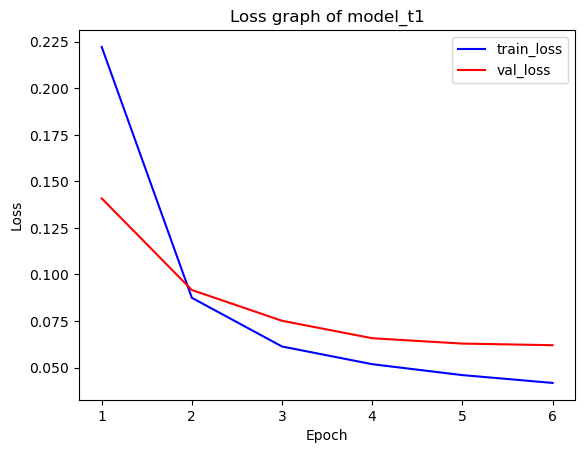

In [ ]:
model_name= "model_t1"
graph_loss()

In [ ]:
model_t1.evaluate(test_df)

32/32 [==============================] - 0s 2ms/step - loss: 0.1164 - f1_score: 0.1514


[0.1164141446352005, 0.15135447680950165]

In [ ]:
y_pred2 = model_t1.predict(x_test)
y_pred2 = np.argmax(y_pred2, axis=1)
print("Classification Report: \n", classification_report(y_test, y_pred2))

16/16 [==============================] - 0s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       456
           1       0.87      0.59      0.70        44

    accuracy                           0.96       500
   macro avg       0.91      0.79      0.84       500
weighted avg       0.95      0.96      0.95       500



## tunner input_shape

In [ ]:
def model_builder(hp):

    hp_units = hp.Int('neurons', min_value=2, max_value=128, step=2)
    model = Sequential([
        Dense(units=hp_units, activation='relu', input_shape=(18,)),
        #model.add(keras.layers.Dense(units=hp_units, activation='relu'))
        #model.add(keras.layers.Dense(units=hp_units, activation='relu'))
        Dense(2, activation="softmax")
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer= Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[f1_score])

    return model

In [ ]:
objective = kt.Objective("val_f1_score", direction="max")

tunner = kt.Hyperband(model_builder,
                     objective= objective,
                     max_epochs=8,
                     factor=3,
                     directory='my_dir',
                     project_name='fraud',
                     overwrite= True)

early_stopping_callback = EarlyStopping(mode="max", patience=5, restore_best_weights=True)
tunner.search(train_df, validation_data=val_df, epochs=120, callbacks=[early_stopping_callback])

best_hps=tunner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of neurons is {best_hps.get('neurons')} with the optimal learning rate is {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 00m 04s]
val_f1_score: 0.1880839318037033

Best val_f1_score So Far: 0.1880839318037033
Total elapsed time: 00h 00m 30s
The optimal number of neurons is 18 with the optimal learning rate is 0.01


In [ ]:
def model_builder(hp):

    hp_units = hp.Int('neurons', min_value=2, max_value=128, step=2)
    model = Sequential([
        Dense(units=18, activation='relu', input_shape=(18,)),
        Dense(units=10, activation='relu', input_shape=(18,)),
        #model.add(keras.layers.Dense(units=hp_units, activation='relu'))
        Dense(2, activation="softmax")
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer= Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[f1_score])

    return model

In [ ]:
objective = kt.Objective("val_f1_score", direction="max")

tunner = kt.Hyperband(model_builder,
                     objective= objective,
                     max_epochs=8,
                     factor=3,
                     directory='my_dir',
                     project_name='fraud',
                     overwrite= True)

early_stopping_callback = EarlyStopping(mode="max", patience=5, restore_best_weights=True)
tunner.search(train_df, validation_data=val_df, epochs=120, callbacks=[early_stopping_callback])

best_hps=tunner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of neurons is {best_hps.get('neurons')} with the optimal learning rate is {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 00m 04s]
val_f1_score: 0.1880839318037033

Best val_f1_score So Far: 0.1880839318037033
Total elapsed time: 00h 00m 34s
The optimal number of neurons is 98 with the optimal learning rate is 0.0001


In [ ]:
model_t2 = Sequential([
    Dense(18, activation="relu", input_shape=(18,)),
    Dense(10, activation="relu"),
    Dense(98, activation="relu"),
    Dense(2, activation="softmax")
])
model_t2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 18)                342       
                                                                 
 dense_4 (Dense)             (None, 10)                190       
                                                                 
 dense_5 (Dense)             (None, 98)                1078      
                                                                 
 dense_6 (Dense)             (None, 2)                 198       
                                                                 
Total params: 1808 (7.06 KB)
Trainable params: 1808 (7.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_t2.compile(optimizer='Adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[f1_score])

early_stopping = EarlyStopping(mode="max", patience=5, restore_best_weights=True)

model_history = model_t2.fit(train_df, validation_data=val_df, epochs=120,
                              callbacks=[early_stopping])

Epoch 1/120
250/250 [==============================] - 1s 3ms/step - loss: 0.2777 - f1_score: 0.1648 - val_loss: 0.1958 - val_f1_score: 0.1881
Epoch 2/120
250/250 [==============================] - 0s 2ms/step - loss: 0.1175 - f1_score: 0.1648 - val_loss: 0.1158 - val_f1_score: 0.1881
Epoch 3/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0784 - f1_score: 0.1648 - val_loss: 0.0815 - val_f1_score: 0.1881
Epoch 4/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0650 - f1_score: 0.1648 - val_loss: 0.0700 - val_f1_score: 0.1881
Epoch 5/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0592 - f1_score: 0.1648 - val_loss: 0.0625 - val_f1_score: 0.1881
Epoch 6/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0548 - f1_score: 0.1648 - val_loss: 0.0604 - val_f1_score: 0.1881


In [ ]:
y_pred2 = model_t2.predict(x_test)
y_pred2 = np.argmax(y_pred2, axis=1)
print("Classification Report: \n", classification_report(y_test, y_pred2))

16/16 [==============================] - 0s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       456
           1       0.95      0.41      0.57        44

    accuracy                           0.95       500
   macro avg       0.95      0.70      0.77       500
weighted avg       0.95      0.95      0.94       500



In [ ]:
model_t2 = Sequential([
    Dense(26, activation="relu", input_shape=(18,)),
    Dense(93, activation="relu"),
    Dense(56, activation="relu"),
    Dense(2, activation="softmax")
])
model_t2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 26)                494       
                                                                 
 dense_28 (Dense)            (None, 93)                2511      
                                                                 
 dense_29 (Dense)            (None, 56)                5264      
                                                                 
 dense_30 (Dense)            (None, 2)                 114       
                                                                 
Total params: 8383 (32.75 KB)
Trainable params: 8383 (32.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_t2.compile(optimizer='Adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[f1_score])

early_stopping = EarlyStopping(mode="max", patience=5, restore_best_weights=True)

model_history = model_t2.fit(train_df, validation_data=val_df, epochs=120,
                              callbacks=[early_stopping])

Epoch 1/120
250/250 [==============================] - 1s 3ms/step - loss: 0.1688 - f1_score: 0.1648 - val_loss: 0.1210 - val_f1_score: 0.1881
Epoch 2/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0821 - f1_score: 0.1648 - val_loss: 0.0855 - val_f1_score: 0.1881
Epoch 3/120
250/250 [==============================] - 1s 2ms/step - loss: 0.0642 - f1_score: 0.1648 - val_loss: 0.0701 - val_f1_score: 0.1881
Epoch 4/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0546 - f1_score: 0.1648 - val_loss: 0.0648 - val_f1_score: 0.1881
Epoch 5/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0486 - f1_score: 0.1648 - val_loss: 0.0622 - val_f1_score: 0.1881
Epoch 6/120
250/250 [==============================] - 0s 2ms/step - loss: 0.0438 - f1_score: 0.1648 - val_loss: 0.0608 - val_f1_score: 0.1881


In [ ]:
y_pred2 = model_t2.predict(x_test)
y_pred2 = np.argmax(y_pred2, axis=1)
print("Classification Report: \n", classification_report(y_test, y_pred2))

16/16 [==============================] - 0s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       456
           1       0.97      0.73      0.83        44

    accuracy                           0.97       500
   macro avg       0.97      0.86      0.91       500
weighted avg       0.97      0.97      0.97       500



# tunning gridsearch

In [ ]:
def define_model(dropout_rate=0.0, neurons=10, lr=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(18,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer= Adam(lr),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[f1_score])
    return model

In [ ]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=define_model, verbose=1,epoch=10)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'dropout_rate': [0.0, 0.3, 0.5],
    'weight_constraint': [1, 2, 3],
    'neurons': [8, 18, 36],
    'lr': [0.001, 0.01, 0.1]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=3)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

ValueError: Invalid parameter dropout_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(dropout_rate=0.0)`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
!pip install pyLDAvis==2.1.2

     ---------------------------------------- 1.6/1.6 MB 563.9 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97721 sha256=3cc92a37f60db4f5a66e4bb1c380827950b583a1e42365a870b4b6c3fd009bd0
  Stored in directory: c:\users\jennifer patricia\appdata\local\pip\cache\wheels\59\70\ee\99a0df99d8b4a7b87c79640ebee0927c0f6ccff046e9cc2471
Successfully built pyLDAvis
